In [1]:
import os
import csv
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from random import shuffle

%matplotlib inline

In [2]:
# input files
bounds = '/home/bo/Dataset/road_arrow/first_iteration/atlas_nrw_dop10_road_arrow_classification_v2_train_patch_bounds_filtered_no_overlaps.geojson'
label = '/home/bo/Dataset/road_arrow/first_iteration/atlas_nrw_dop10_road_arrow_classification_v2_train_labels_raw_filtered_no_overlaps.geojson'
statis = '/home/bo/Dataset/road_arrow/first_iteration/atlas_nrw_dop10_road_arrow_classification_v2_train_arrows_mask_stats.csv'

# read input files
bounds = gpd.read_file(bounds)
label = gpd.read_file(label)
statis = pd.read_csv(statis)

# give a list of category use for training, the label file might contains more, like "Other, U-turn".
category_list = ['Straight-Right Arrow',
                 'Straight-Left Arrow',
                 'Straight Arrow',
                 'Slightly-Right Arrow',
                 'Slightly-Left Arrow',
                 'Right Arrow',
                 'Left-Right Arrow',
                 'Left Arrow']
for cat in category_list:
    print(cat, ':  ', len(statis[statis[cat] > 0]))

Straight-Right Arrow :   7628
Straight-Left Arrow :   2812
Straight Arrow :   11363
Slightly-Right Arrow :   664
Slightly-Left Arrow :   309
Right Arrow :   6754
Left-Right Arrow :   453
Left Arrow :   12651


In [3]:
# the folder that you save your annotation files
csv_save_folder = '/home/bo/Dataset/road_arrow/debug/'

# the patch of folder, where the image patches are saved
image_folder = '/home/bo_huang/road_arrow_bbox_dataset/images/'

# specify the number of patches for each category, that you want to put into validation set
category_num = {'Straight-Right Arrow': 100,
                'Straight-Left Arrow': 100,
                'Straight Arrow': 200,
                'Slightly-Right Arrow': 60,
                'Slightly-Left Arrow': 60,
                'Right Arrow': 100,
                'Left-Right Arrow': 60,
                'Left Arrow': 100}

# specify the number of background samples for training and validation set
train_bg_num = 5000
val_bg_num = 500

# training data statistics
train_image_list = []
val_image_list = []

for cat in category_num:
    df = statis[statis[cat] > 0]
    cat_list = np.array(statis[statis[cat] > 0].filename).tolist()
    shuffle(cat_list)
    val_image_list = val_image_list + cat_list[0:category_num[cat]]
    train_image_list = train_image_list + cat_list[category_num[cat]:]

train_image_list = list(set(train_image_list))
val_image_list = list(set(val_image_list))

# background patches
temp = np.zeros(len(statis))
for cat in np.array(statis.keys()):
    if cat == 'filename' or cat == 'background':
        continue
    temp = temp + np.array(statis[cat])
statis['sum_foreground'] = temp
background_image_list = np.array(statis[statis['sum_foreground'] == 0].filename).tolist()
shuffle(background_image_list)
print('total number of background patches:', len(background_image_list))

train_bg_image_list = background_image_list[0:train_bg_num]
val_bg_image_list = background_image_list[train_bg_num: train_bg_num + val_bg_num]

total number of background patches: 57607


In [11]:
# main 
# convert data into the format that support the training of retina-Net

# save class mapping
with open(os.path.join(csv_save_folder, 'class_mapping.csv'), 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for cat_num, cat in enumerate(category_list):
        spamwriter.writerow([cat, cat_num + 1])
    spamwriter.writerow(['background', 0])


# run training set
print('start to generate annotations for training set ...')
with open(os.path.join(csv_save_folder, 'train_foreground.csv'), 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idd, file_name in enumerate(train_image_list):
        raw = label[label.patch_id == file_name + '.jpg']
        for i in range(len(raw)):
            filepath = image_folder + os.path.split(raw.iloc[i].filename)[-1]
            x1 = int(raw.iloc[i].geometry.bounds[0])
            y1 = int(raw.iloc[i].geometry.bounds[1])
            x2 = int(raw.iloc[i].geometry.bounds[2])
            y2 = int(raw.iloc[i].geometry.bounds[3])
            class_name = raw.iloc[i].category
            
            if class_name not in category_list:
                print('remove category:', class_name)
                continue
            if x1 > x2 or y1 > y2 or x1 <0 or y1 <0:
                print("remove wrong bbox:", x1,y1,x2,y2)
                continue
            
            spamwriter.writerow([filepath, x1, y1, x2, y2, class_name])
#         if idd == 50:
#             break
            
# run validation set
print('start to generate annotations for validation set ...')
with open(os.path.join(csv_save_folder, 'val_foreground.csv'), 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idd, file_name in enumerate(val_image_list):
        raw = label[label.patch_id == file_name + '.jpg']
        for i in range(len(raw)):
            filepath = image_folder + os.path.split(raw.iloc[i].filename)[-1]
            x1 = int(raw.iloc[i].geometry.bounds[0])
            y1 = int(raw.iloc[i].geometry.bounds[1])
            x2 = int(raw.iloc[i].geometry.bounds[2])
            y2 = int(raw.iloc[i].geometry.bounds[3])
            class_name = raw.iloc[i].category
            
            if class_name not in category_list:
                print('remove category:', class_name)
                continue
            if x1 > x2 or y1 > y2 or x1 <0 or y1 <0:
                print("remove wrong bbox:", x1, y1, x2, y2)
                continue
            
            spamwriter.writerow([filepath, x1, y1, x2, y2, class_name])
#         if idd == 50:
#             break
            
# generating background annotation for training set and validation set
print('start to generate background annotations for training and validation set ...')
with open(os.path.join(csv_save_folder, 'train_background.csv'), 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idd, file_name in enumerate(train_bg_image_list):
        raw = label[label.patch_id == file_name + '.jpg']
        for i in range(len(raw)):
            filepath = image_folder + os.path.split(raw.iloc[i].filename)[-1]
            x1 = ''
            y1 = ''
            x2 = ''
            y2 = ''
            class_name = ''
            
            spamwriter.writerow([filepath, x1, y1, x2, y2, class_name])
#         if idd == 50:
#             break
            
with open(os.path.join(csv_save_folder, 'val_background.csv'), 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idd, file_name in enumerate(val_bg_image_list):
        raw = label[label.patch_id == file_name + '.jpg']
        for i in range(len(raw)):
            filepath = image_folder + os.path.split(raw.iloc[i].filename)[-1]
            x1 = ''
            y1 = ''
            x2 = ''
            y2 = ''
            class_name = ''
            
            spamwriter.writerow([filepath, x1, y1, x2, y2, class_name])
#         if idd == 50:
#             break

            
# combine
interesting_files = [os.path.join(csv_save_folder, 'train_foreground.csv'), 
                     os.path.join(csv_save_folder, 'train_background.csv')]
df = pd.concat((pd.read_csv(f, header = None) for f in interesting_files))
df.to_csv(os.path.join(csv_save_folder, 'combine_train.csv'), index=False, header=None)

interesting_files = [os.path.join(csv_save_folder, 'val_foreground.csv'), 
                     os.path.join(csv_save_folder, 'val_background.csv')]
df = pd.concat((pd.read_csv(f, header = None) for f in interesting_files))
df.to_csv(os.path.join(csv_save_folder, 'combine_val.csv'), index=False, header=None)

start to generate annotations for training set ...
remove category: Other
remove category: Other
start to generate annotations for validation set ...
remove category: Other
remove category: Other
remove category: Other
remove category: Other
remove category: Other
start to generate background annotations for training and validation set ...


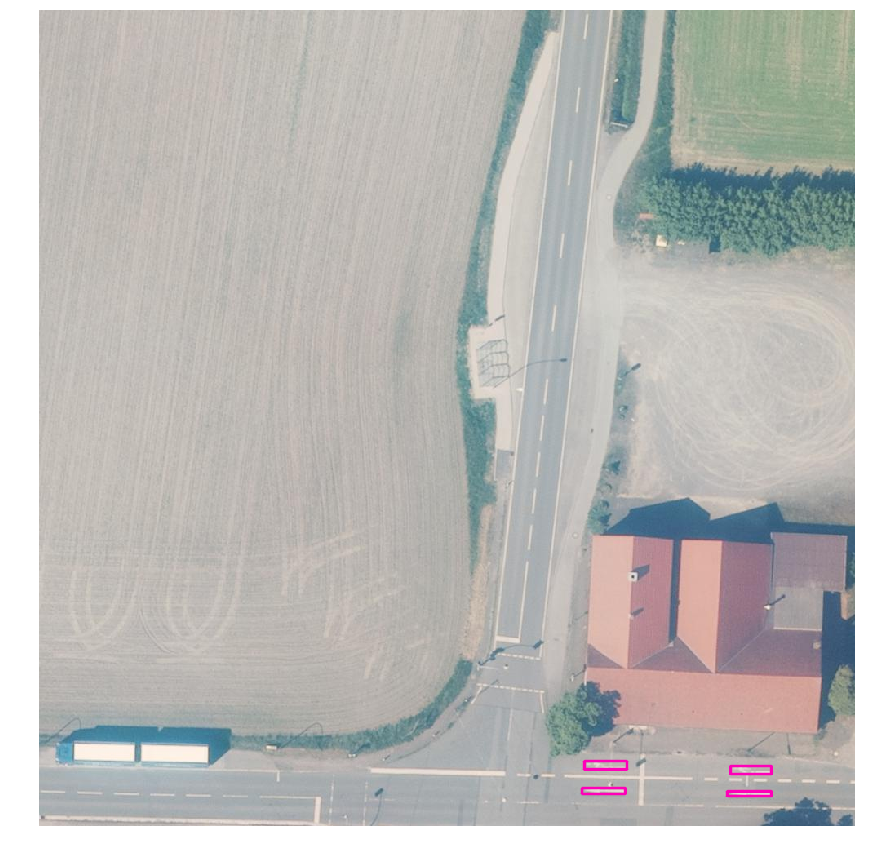

In [71]:
import cv2

def draw_box(image, box, color, thickness=2):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)
    
# visualize the annotation
img = cv2.imread('/home/bo/Desktop/trafficsignals_473900_5800300.jpg')
df_temp = label[label.patch_id == 'trafficsignals_473900_5800300.jpg']

# visualize detections
for i in range(len(df_temp)):
    
    x1 = int(df_temp.iloc[i].geometry.bounds[0])
    y1 = int(df_temp.iloc[i].geometry.bounds[1])
    x2 = int(df_temp.iloc[i].geometry.bounds[2])
    y2 = int(df_temp.iloc[i].geometry.bounds[3])
    b = np.array([x1, y1, x2, y2]).astype(int)

    draw_box(img, b, color=[184 , 0   , 255])
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(img[:,:,::-1])
plt.show()